In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

import torch

import warnings
warnings.simplefilter('ignore')

In [3]:
import os
print(os.listdir("../input/nlp-getting-started"))

['sample_submission.csv', 'train.csv', 'test.csv']


In [4]:
train_tweet= pd.read_csv('../input/nlp-getting-started/train.csv')
test_tweet=pd.read_csv('../input/nlp-getting-started/test.csv')

let's check what features does our dataset contains and dimension of our trrain and test dataset

In [5]:
print('There are {} rows and {} columns in train'.format(train_tweet.shape[0],train_tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test_tweet.shape[0],test_tweet.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [6]:
train_tweet.sample(5)

,id,keyword,location,text,target
6573,9406,survivors,"SÌ£o Paulo, Brasil",Hiroshima survivors fight nuclear industry in ...,1
3546,5069,famine,PanamÌÁ,Top 3:\n* Turn on the Darkness\n* King Redeem ...,0
4997,7129,military,Boston MA,13 reasons why we love women in the military ...,0
4471,6358,hostages,"Tampa, Fl",C-130 specially modified to land in a stadium ...,1
5145,7337,nuclear%20reactor,NaN,Salem 2 nuclear reactor shut down over electri...,1


*How disaster and non-disaster tweets look like in our train set (Validating from a sample of tweets)*

In [7]:
## Disaster tweets
train_tweet[train_tweet['target']==1]['text'].values[:3]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"],
      dtype=object)

In [8]:
## Non disaster tweets
train_tweet[train_tweet['target']==0]['text'].values[:3]

array(["What's up man?", 'I love fruits', 'Summer is lovely'],
      dtype=object)

**From above samples we have validated that our train set contains the valid disaster and non-disaster tweets**

In [9]:
## check for the missing values in train and test dataset
train_tweet.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
test_tweet.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

We can see there are lot of miisng values  in the location column for both train and test data. Since we only be making use of text column for our analyssi there is no point in imputing the missing values at this point.

### Exploratory Data Analysis

<AxesSubplot:ylabel='target'>

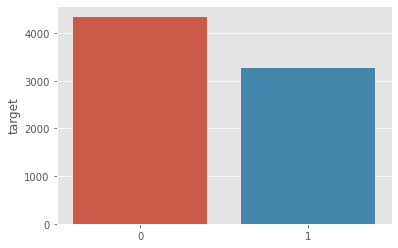

In [11]:
## target distribution in our training set
sns.barplot(train_tweet['target'].value_counts().index,train_tweet['target'].value_counts())

<AxesSubplot:xlabel='keyword'>

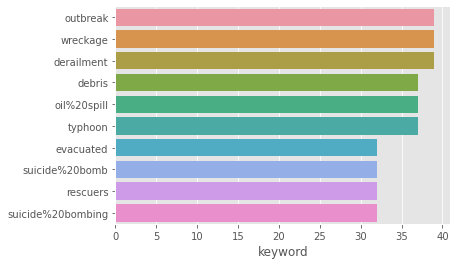

In [12]:
## Check for the most frequently used keywords in each type of tweets

## disaster tweets

sns.barplot(y=train_tweet[train_tweet['target']==1]['keyword'].value_counts()[:10].index,x=train_tweet[train_tweet['target']==1]['keyword'].value_counts()[:10],orient='h')

<AxesSubplot:xlabel='keyword'>

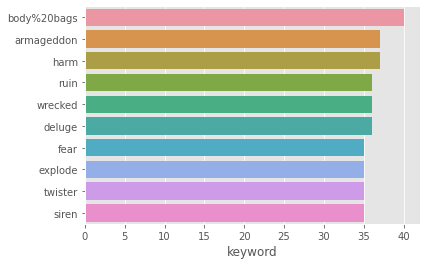

In [13]:
## Non Disaster tweets

sns.barplot(y=train_tweet[train_tweet['target']==0]['keyword'].value_counts()[:10].index,x=train_tweet[train_tweet['target']==0]['keyword'].value_counts()[:10],orient='h')

In [14]:
# Text Preprocessing ( Helper function)
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text




In [15]:
# Applying the cleaning function to both test and training datasets
train_tweet['text'] = train_tweet['text'].apply(lambda x: clean_text(x))
test_tweet['text'] = test_tweet['text'].apply(lambda x: clean_text(x))

Let's create a WOR CLOUD to check the most frequently occuring words with respect to both Disaster and Non-Disaster tweets

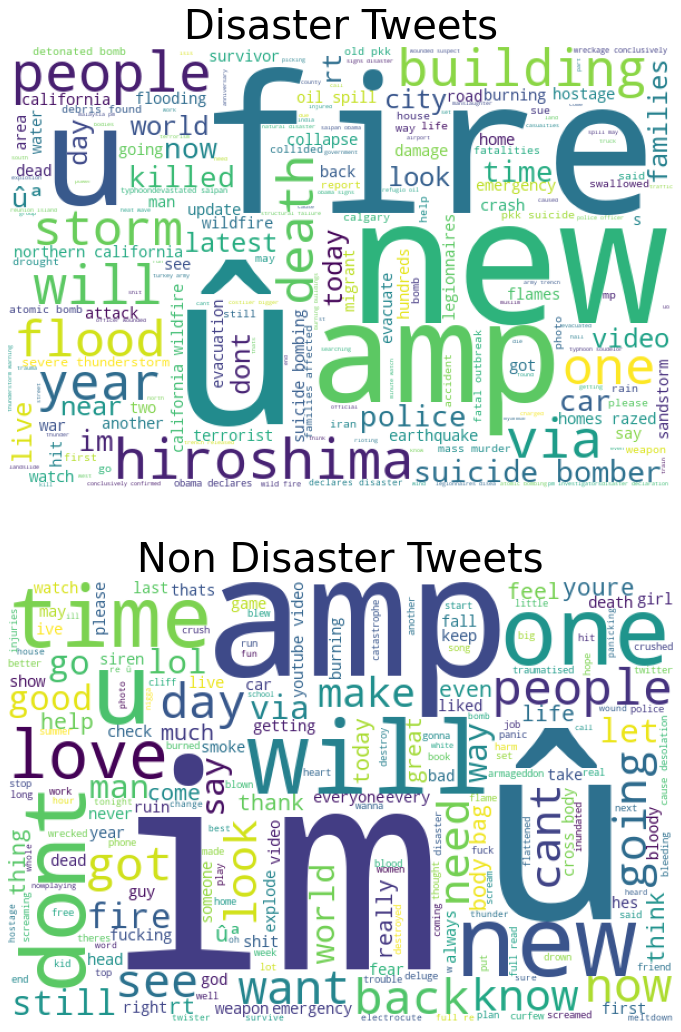

In [16]:
# A disaster tweet
disaster_tweets = train_tweet[train_tweet['target']==1]['text']

#not a disaster tweet
non_disaster_tweets = train_tweet[train_tweet['target']==0]['text']

from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[26, 18])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

Time to explore some meta information for different tweets and see fi we are able to figure out any differences with respect to these properties.

#### Distribution of number of words for each tweet type

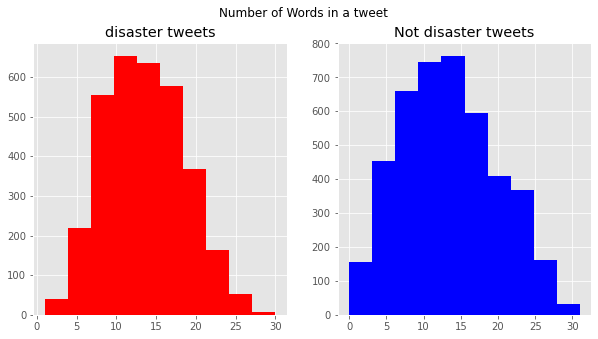

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_tweet[train_tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train_tweet[train_tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='blue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Number of Words in a tweet')
plt.show()

#### Distribution of number of characters for each tweet type

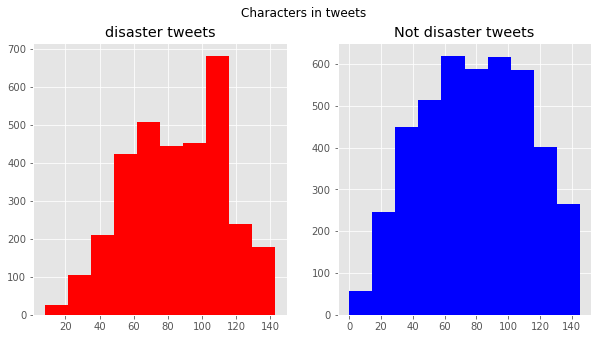

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_tweet[train_tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train_tweet[train_tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='blue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

**Number of words and the length of the tweets does not provide any concrete information with respect to the tweet type**

In [19]:
train_tweet['text'] 

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3        people receive wildfires evacuation orders in...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610                                 s of volcano hawaii 
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

Still we can see our unnecessary words that is stop words that are not useful in classfication task. We can will remove them in our next preprocessing step .

In [20]:
# text preprocessing function
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [21]:
# Applying the cleaning function to both test and training datasets
train_tweet['text'] = train_tweet['text'].apply(lambda x: text_preprocessing(x))
test_tweet['text'] = test_tweet['text'].apply(lambda x: text_preprocessing(x))

In [22]:
train_tweet['text'][:5]

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

## Data Preparation (Textual Data)

### Countvectorizer

In [23]:
## Applying Countvectorizer
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))

In [24]:
train_vectors = cv.fit_transform(train_tweet['text'])
test_vectors = cv.transform(test_tweet["text"])

In [25]:
train_vectors.shape

(7613, 5000)

In [26]:
cv.get_feature_names()[:20]

['aba',
 'aba woman',
 'aba woman delivers',
 'abandoned',
 'abandoned aircraft',
 'abandoned aircraft mma',
 'abc',
 'abc news',
 'abcnews',
 'ablaze',
 'able',
 'absolutely',
 'abstorm',
 'abuse',
 'access',
 'access secrets',
 'access secrets top',
 'accident',
 'accident experts',
 'accident man']

In [27]:
## train-test split

## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_vectors, train_tweet['target'], test_size=0.33, random_state=0)

In [28]:
## applied with TfidfVectorizer

## TFidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))

train_vectors_tfidf = tfidf_v.fit_transform(train_tweet['text'])
test_vectors_tfidf = tfidf_v.transform(test_tweet["text"])

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(train_vectors_tfidf, train_tweet['target'], test_size=0.33, random_state=0)


In [29]:

import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
from sklearn import metrics
import numpy as np
import itertools

### **MultinomialNB**

accuracy:   0.799
Confusion matrix, without normalization


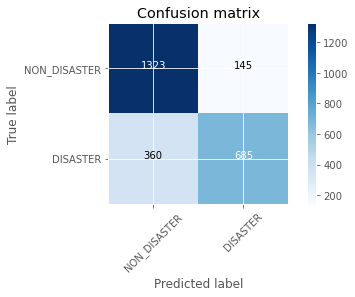

In [31]:
from sklearn.naive_bayes import MultinomialNB
classifier_count=MultinomialNB()


## applied with countVectorizer
classifier_count.fit(X_train, y_train)
pred = classifier_count.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['NON_DISASTER', 'DISASTER'])

accuracy:   0.799
Confusion matrix, without normalization


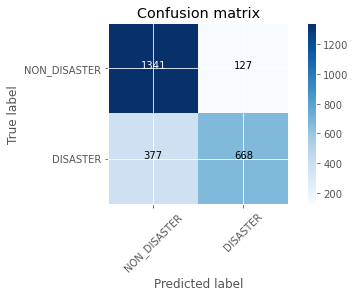

In [32]:
from sklearn.naive_bayes import MultinomialNB
classifier_tfidf=MultinomialNB()

## applied with TfidfVectorizer
classifier_tfidf.fit(X_train_tfidf, y_train_tfidf)
pred = classifier_tfidf.predict(X_test_tfidf)
score = metrics.accuracy_score(y_test_tfidf, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test_tfidf, pred)
plot_confusion_matrix(cm, classes=['NON_DISASTER', 'DISASTER'])


## Passive Aggressive Classifier Algorithm

accuracy:   0.726
Confusion matrix, without normalization


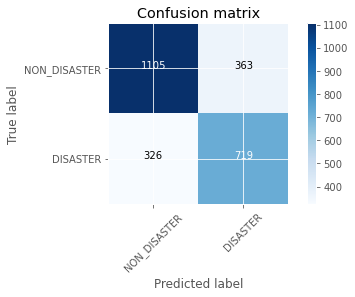

In [33]:
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier()


## applied with countVectorizer
linear_clf.fit(X_train, y_train)
pred = linear_clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['NON_DISASTER', 'DISASTER'])

accuracy:   0.725
Confusion matrix, without normalization


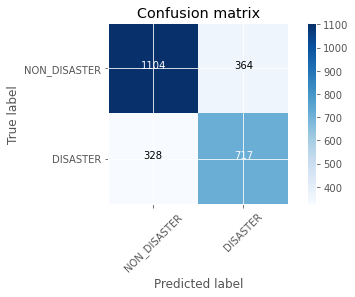

In [34]:
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier()

## applied with TfidfVectorizer
linear_clf.fit(X_train_tfidf, y_train_tfidf)
pred = linear_clf.predict(X_test_tfidf)
score = metrics.accuracy_score(y_test_tfidf, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['NON_DISASTER', 'DISASTER'])

## Submission

In [35]:
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)

In [36]:

## file path = ../input/nlp-getting-started/sample_submission.csv
submission_file_path = "../input/nlp-getting-started/sample_submission.csv"
test_vectors=test_vectors_tfidf
submission(submission_file_path,classifier_tfidf,test_vectors)